In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import logging
import argparse
import glob
import json
from multiprocessing import Pool
import random

import numpy as np
import matplotlib
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown
import statsmodels.api as sm

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses, dirichlet_stats
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils
from zoobot import label_metadata

In [3]:
os.chdir('/home/walml/repos/zoobot')

In [4]:

# questions = [
#     'smooth-or-featured',
#     'has-spiral-arms',
# #     'spiral-winding',
#     'bar',
#     'bulge-size'
# ]

questions = label_metadata.decals_questions

In [5]:
# gz2 cols
# version = 'gz2'
# label_cols = [
#     'smooth-or-featured_smooth',
#     'smooth-or-featured_featured-or-disk',
#     'has-spiral-arms_yes',
#     'has-spiral-arms_no',
#     'bar_yes',
#     'bar_no',
#     'bulge-size_dominant',
#     'bulge-size_obvious',
#     'bulge-size_just-noticeable',
#     'bulge-size_no'
# ]

version='decals'
label_cols = label_metadata.decals_label_cols

In [6]:
schema = losses.Schema(label_cols, questions, version=version)
# schema.questions

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


In [7]:
# df_a = pd.read_csv('temp/gz2_filtered_2p5_eval.csv')
# df_b = pd.read_csv('temp/gz2_all_2p5_eval.csv')

In [8]:
# catalog_loc = 'data/gz2/gz2_master_catalog.csv'
# catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
# catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/gz2' + x[32:])

catalog_loc = 'data/decals/decals_master_catalog.csv'
catalog = pd.read_csv(catalog_loc, dtype={'subject_id': str})  # original catalog
# catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/gz2' + x[32:])
catalog['file_loc'] = catalog['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))
retired = catalog[catalog['smooth-or-featured_total-votes'] > 35]


In [9]:
# df_a = pd.read_csv('temp/offline_decals_all_2p5_unfiltered_n2_b7.csv')
# df_b = pd.read_csv('temp/decals_n2_allq_m0.csv')
# predictions_loc =   
# df_a = pd.read_csv('results/decals_dr_full_m0_eval_predictions.csv')  # .1-20

df_c = pd.read_csv('results/decals_dr_full_m0_eval_predictions.csv')

df_a = pd.read_csv('results/decals_dr_full_m1_eval_predictions.csv')
# df_b = pd.read_csv('results/decals_dr_full_1_to_100_eval_predictions.csv')
df_b = pd.read_csv('results/decals_dr_full_m2_eval_predictions.csv')

df_a = df_a.sort_values('id_str')
df_b = df_b.sort_values('id_str')
df_c = df_c.sort_values('id_str')

df_a['file_loc'] = df_a['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))
df_b['file_loc'] = df_b['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))
df_c['file_loc'] = df_c['local_png_loc'].apply(lambda x: '/media/walml/beta/decals' + x.replace('/data/phys-zooniverse/chri5177', ''))


In [10]:
eval_df = pd.read_csv('results/decals_dr_full_eval_df.csv')
id_strs = set(eval_df['id_str'])

# in eval df
df_a = df_a[df_a['id_str'].isin(id_strs)]
df_b = df_b[df_b['id_str'].isin(id_strs)]
df_c = df_c[df_c['id_str'].isin(id_strs)]

# only featured for now
df_a = df_a[df_a['smooth-or-featured_featured-or-disk_fraction'] > 0.5]
df_b = df_b[df_b['smooth-or-featured_featured-or-disk_fraction'] > 0.5]
df_c = df_c[df_c['smooth-or-featured_featured-or-disk_fraction'] > 0.5]

# not edge on disk for now
df_a = df_a[df_a['disk-edge-on_no'] > 0.5]
df_b = df_b[df_b['disk-edge-on_no'] > 0.5]
df_c = df_c[df_c['disk-edge-on_no'] > 0.5]

# only highly classified for now
# df_a = df_a[df_a['id_str'].isin(retired['id_str'])]
# df_b = df_b[df_b['id_str'].isin(retired['id_str'])]
# df_c = df_c[df_c['id_str'].isin(retired['id_str'])]

In [11]:
assert (df_a['iauname'] == df_b['iauname']).all()

In [12]:
def get_concentrations(df, answer_text):
    return np.array([json.loads(x) for x in df[answer_text + '_concentration']])

In [13]:
def get_all_concentrations(df, schema):
    concentrations = []
    for a in schema.answers:
        concentrations.append(np.array([json.loads(x) for x in df[a.text + '_concentration']]))
    return np.array(concentrations).transpose(1, 0, 2).astype(np.float32)

In [14]:
df_a_conc = get_all_concentrations(df_a, schema)
df_b_conc = get_all_concentrations(df_b, schema)
df_a_conc.shape

(12293, 34, 5)

In [15]:
df_a_conc[0, :2, 0]

array([ 2.6699858, 72.60027  ], dtype=float32)

In [16]:
df_b_conc[0, :2, 0]

array([ 4.0053663, 76.95636  ], dtype=float32)

In [17]:
expected_a = dirichlet_stats.dirichlet_prob_of_answers(df_a_conc, schema)
for a_n, a in enumerate(schema.answers):
    df_a[a.text + '_prediction_mean'] = expected_a[:, a_n]
    
expected_b = dirichlet_stats.dirichlet_prob_of_answers(df_b_conc, schema)
for a_n, a in enumerate(schema.answers):
    df_b[a.text + '_prediction_mean'] = expected_b[:, a_n]

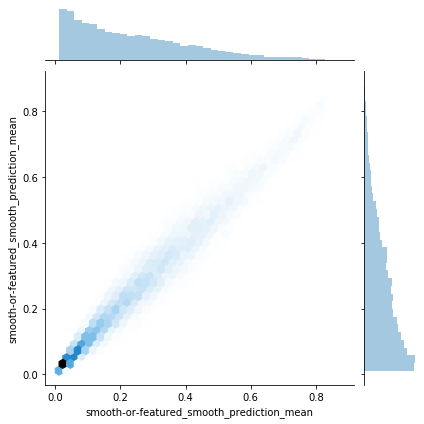

In [18]:
sns.jointplot(df_a['smooth-or-featured_smooth_prediction_mean'], df_b['smooth-or-featured_smooth_prediction_mean'], kind='hex')
# plt.xlim([0., 0.5])
# plt.ylim([0., 0.5])

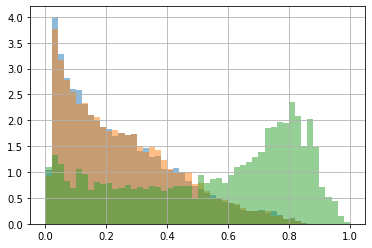

In [19]:
_, bins = np.histogram(np.linspace(0., 1.), bins=50)
df_a['smooth-or-featured_smooth_prediction_mean'].hist(bins=bins, alpha=.5, density=True)
df_b['smooth-or-featured_smooth_prediction_mean'].hist(bins=bins, alpha=.5, density=True)
retired['smooth-or-featured_smooth_fraction'].hist(bins=bins, alpha=.5, density=True)

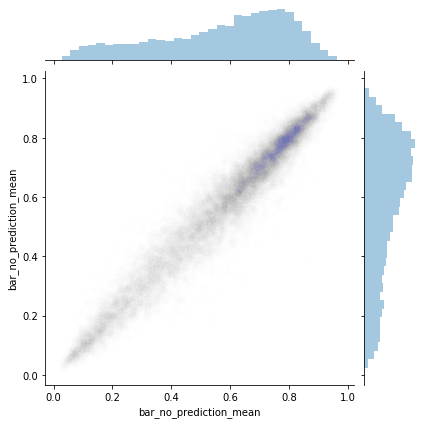

In [20]:
sns.jointplot(df_a['bar_no_prediction_mean'], df_b['bar_no_prediction_mean'], alpha=0.005)

In [21]:
samples_list = [df_a_conc, df_b_conc]

In [22]:
import tensorflow_probability as tfp

In [23]:
import matplotlib as mpl
cycler = mpl.rcParams['axes.prop_cycle']
# https://matplotlib.org/cycler/
colors = [c['color'] for c in cycler]

In [24]:
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [25]:
assert len(colors) > len(samples_list)

In [26]:
# question = schema.get_question('smooth-or-featured')
# question = schema.get_question('disk-edge-on')
question = schema.get_question('has-spiral-arms')
# question = schema.get_question('bar')
answer = question.answers[0]
answer.text

'has-spiral-arms_yes'

In [27]:
# initial_size = 300
# # eval_locs = glob.glob(f'/home/walml/repos/zoobot/data/gz2/shards/all_featp5_facep5_sim_2p5_{initial_size}/eval_shards/*.tfrecord')
# # tfrecord_locs = train_locs + eval_locs
# tfrecord_locs = eval_locs

# initial_size = 300
# tfrecord_locs = glob.glob('/media/walml/beta/galaxy_zoo/decals/all_2p5_unfiltered_n2_eval_shards/eval_shards/*.tfrecord')
# tfrecord_locs = glob.glob('/media/walml/beta/temp/decals_dr_full_eval_shards/eval_shards/*.tfrecord')[:4]

In [28]:
# feature_spec = input_utils.get_feature_spec({'id_str': 'string'})
# id_str_dataset = input_utils.get_dataset(tfrecord_locs, feature_spec, batch_size=1, shuffle=False, repeat=False, drop_remainder=False)
# id_strs = set([str(d['id_str'].numpy().squeeze())[2:-1] for d in id_str_dataset])

In [29]:
from matplotlib.ticker import MaxNLocator

In [30]:
# int_format = StrMethodFormatter('{:.0f}')


In [31]:
# continuous posteriors, looks much prettier but technically not defined for non-integer votes
def show_predictions(prediction_dfs, question, answer, sort_order=None, n_examples=5):  
    
    # assume prediction_dfs are aligned
    samples_list = [get_all_concentrations(df, schema) for df in prediction_dfs]

    fig, axes = plt.subplots(nrows=n_examples, ncols=2, figsize=(6.8, 3 * n_examples), gridspec_kw={'hspace': .4})
    for n in range(n_examples):
        
        galaxy = prediction_dfs[0].iloc[n]
        assert not galaxy.empty
        row = axes[n]
#         total_votes = galaxy['smooth-or-featured_total-votes'].astype(np.float32)
        total_votes = galaxy['smooth-or-featured_featured-or-disk'].astype(np.float32)
        votes = np.linspace(0., total_votes)
#         print(votes, total_votes)
        x = np.stack([votes, total_votes-votes], axis=-1)  # also need the counts for other answer, no
        votes_this_answer = x[:, answer.index - question.start_index]

        for model_n, samples in enumerate(samples_list):
            ax = row[0]

            all_log_probs = []
            color = colors[model_n]
            n_samples = samples.shape[2]
            for d in range(n_samples):
#                 print(question.start_index, question.end_index
                concentrations = tf.constant(samples[n, question.start_index:question.end_index+1, d].astype(np.float32))
#                 print(samples_sorted.shape)
#                 print(total_votes, concentrations, x)
                log_probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(x)
                all_log_probs.append(log_probs)
                ax.plot(votes_this_answer, log_probs, alpha=.15, color=color)
            all_log_probs = np.array(all_log_probs).mean(axis=0)
            ax.plot(votes_this_answer, all_log_probs, linewidth=2., color=color)
            
            actual_votes = galaxy[answer.text]
            # avoid disappearing off the side
            viz_offset = 0.004
            if actual_votes == 0:
                actual_votes += viz_offset * total_votes
            if n == 4:  # final galaxy with 40 votes happens to have 0 votes for spiral, is off the side
                actual_votes += 1.7 * viz_offset * total_votes # slightly less offset for the width of line itself
            ax.axvline(actual_votes, color='k', linestyle='--', linewidth=2.)
            ax.set_xlim([0., total_votes])
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_ylabel(r'$p$(votes)')
            
            ax = row[1]
            ax.imshow(np.array(Image.open(galaxy['file_loc'].replace('beta', 'beta1'))))
            ax.axis('off')
        
        # last row, left side
        ax = axes[-1][0]
        ax.set_xlabel('"Has Spiral Arms" votes')


In [32]:
# # actual discrete predictions, uglier but technically more correct
# def show_predictions(prediction_dfs, question, answer, sort_order=None, n_examples=5):  
    
#     # assume prediction_dfs are aligned
#     samples_list = [get_all_concentrations(df, schema) for df in prediction_dfs]

#     fig, axes = plt.subplots(nrows=n_examples, ncols=2, figsize=(6.8, 3 * n_examples), gridspec_kw={'hspace': .4})
#     for n in range(n_examples):
        
#         galaxy = prediction_dfs[0].iloc[n]
#         assert not galaxy.empty
#         row = axes[n]
# #         total_votes = galaxy['smooth-or-featured_total-votes'].astype(np.float32)
#         total_votes = galaxy['smooth-or-featured_featured-or-disk'].astype(np.float32)
#         votes = np.arange(0., total_votes+1)
# #         print(votes, total_votes)
#         x = np.stack([votes, total_votes-votes], axis=-1)  # also need the counts for other answer, no
#         votes_this_answer = x[:, answer.index - question.start_index]

#         for model_n, samples in enumerate(samples_list):
#             ax = row[0]

#             all_log_probs = []
#             color = colors[model_n]
#             n_samples = samples.shape[2]
#             for d in range(n_samples):
# #                 print(question.start_index, question.end_index
#                 concentrations = tf.constant(samples[n, question.start_index:question.end_index+1, d].astype(np.float32))
# #                 print(samples_sorted.shape)
# #                 print(total_votes, concentrations, x)
#                 log_probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations, validate_args=True).prob(x)
#                 all_log_probs.append(log_probs)
#                 ax.plot(votes_this_answer, log_probs, alpha=.15, color=color)
#             all_log_probs = np.array(all_log_probs).mean(axis=0)
# #             ax.plot(votes_this_answer, all_log_probs, linewidth=2., color=color)
            
#             actual_votes = galaxy[answer.text]
#             # avoid disappearing off the side
#             viz_offset = 0.004
#             if actual_votes == 0:
#                 actual_votes += viz_offset * total_votes
#             elif actual_votes == total_votes:
#                 actual_votes -= (viz_offset - 0.003) * total_votes # slightly less offset for the width of line itself
#             ax.axvline(actual_votes, color='k', linestyle='--', linewidth=2.)
#             ax.set_xlim([0., total_votes])
#             ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#             ax.set_ylabel(r'$p$(votes)')
            
#             ax = row[1]
#             ax.imshow(np.array(Image.open(galaxy['file_loc'].replace('beta', 'beta1'))))
#             ax.axis('off')
        
#         # last row, left side
#         ax = axes[-1][0]
#         ax.set_xlabel('"Has Spiral Arms" votes')


In [33]:
# dict(df_a.iloc[1]) 
# blank if nobody answered featured or disk, no right answer

In [34]:
# interestingly, does a reasonable job at predicting has spiral arms even for galaxies most people said were smooth

In [35]:
(df_a['smooth-or-featured_total-votes'] == 40).sum()

664

In [41]:
indices_with_40 = np.arange(len(df_a))[df_a['smooth-or-featured_total-votes'] == 40]
random.Random(1).shuffle(indices_with_40)  # seed was 42 for paper

11942

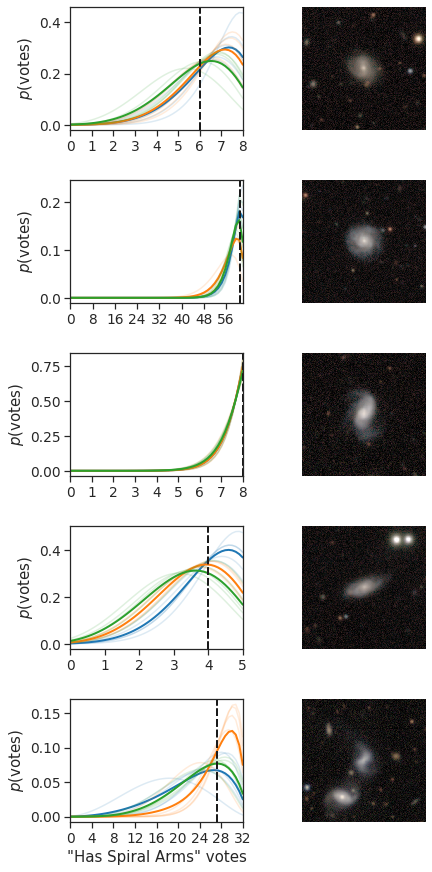

In [45]:
# sns.set_context('notebook')
sns.set(font_scale=1.25, context='notebook')
sns.set_style('ticks')

# totally random
# show_predictions([df_a, df_b, df_c], question, answer, n_examples=5)

# random but def. 40 total votes for smooth/featured
# show_predictions([df_a.iloc[indices_with_40], df_b.iloc[indices_with_40], df_c.iloc[indices_with_40]], question, answer, n_examples=5)

show_predictions([df_a.iloc[11942-4:], df_b.iloc[11942-4:], df_c.iloc[11942-4:]], question, answer, n_examples=5)

# totally random, then one random with 40 for smooth/featured
# indices_to_show = np.array(list(range(4)) + [indices_with_40[0]])
# print(indices_to_show)
# show_predictions([df_a.iloc[indices_to_show], df_b.iloc[indices_to_show], df_c.iloc[indices_to_show]], question, answer, n_examples=5)


# plt.savefig('notebooks/multiq/performance/example_spiral_predictions_inc_n40.png')
# plt.savefig('notebooks/multiq/performance/example_spiral_predictions_inc_n40.pdf')

In [38]:
assert False

AssertionError: 

In [ ]:
samples = np.concatenate([get_all_concentrations(df, schema) for df in [df_a, df_b, df_c]], axis=2)

In [ ]:

def show_multidim_posterior(samples, catalog, question, total_galaxies=5, x_index=0, y_index=1):
    assert x_index != y_index
    assert x_index < 3
    assert y_index < 3

    n_dropout = samples.shape[2]
    fig, axes = plt.subplots(nrows=total_galaxies, ncols=2, figsize=(6.8, 3 * total_galaxies), gridspec_kw={'hspace': .4})
    for n in range(total_galaxies):
        ax = axes[n][0]
        
        galaxy = catalog.iloc[n]
        total_votes = int(galaxy[question.text+'_total-votes'])
        assert total_votes > 0
        actual_votes = galaxy[[a.text for a in question.answers]].values
        
#         print(total_votes, actual_votes)
        permutations = np.array(acquisition_utils.get_discrete_permutations(total_votes, len(question.answers)))
        assert permutations.shape[1] == len(question.answers)
    #     permutations = np.array(list(partitions(total_votes, 3)))
        probs = np.zeros((len(permutations), n_dropout))
        for d in range(n_dropout):
            concentrations = tf.constant(samples[n, question.start_index:question.end_index+1, d].astype(np.float32))
            probs[:, d] = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(permutations)
#         print(permutations.shape, probs.shape)
        sns.scatterplot(permutations[:, x_index], permutations[:, y_index], hue=probs.mean(axis=1), ax=ax, legend=False)
        
#         https://stackoverflow.com/questions/62884183/trying-to-add-a-colorbar-to-a-seaborn-scatterplot
        norm = plt.Normalize(probs.mean(axis=1).min(), probs.mean(axis=1).max())
        sm = plt.cm.ScalarMappable(norm=norm)
        sm.set_array([])
        cbar = ax.figure.colorbar(sm, ax=ax, format=FormatStrFormatter('%.2f'))
#         cbar.ax.set_title(r'$p$')  # in this case, I prefer it without a label or title, poor form but much prettier

#         entropy = np.sum(-probs * np.log(probs))
#         ax.set_title(np.around(entropy, 3))

        ax.scatter(x=actual_votes[x_index], y=actual_votes[y_index], color='k', marker='o', facecolors='none', s=200., alpha=.5)
#         ax.set_xlabel(question.answers[x_index].pretty_text)
#         ax.set_ylabel(question.answers[y_index].pretty_text)
        ax.set_xlabel('Strong Bar')
        ax.set_ylabel('Weak Bar')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
        ax = axes[n][1]
        ax.imshow(np.array(Image.open(galaxy['file_loc'].replace('beta', 'beta1'))))
        ax.axis('off')

    fig.tight_layout()


In [ ]:
# dict(df_a.iloc[10])

In [ ]:
# dict(df_a.iloc[0])

In [ ]:
question = schema.get_question('bar')
assert len(question.answers) == 3
answer = question.answers[0]

answer_a_index = 2
answer_b_index = 3

show_multidim_posterior(samples, df_a.iloc[indices_to_show], question)
plt.savefig('notebooks/multiq/performance/example_bar_predictions_inc_n40.png')
plt.savefig('notebooks/multiq/performance/example_bar_predictions_inc_n40.pdf')